# 使用LeNet在MNIST数据集实现图像分类

**作者:** [PaddlePaddle](https://github.com/PaddlePaddle), [liyongchao911](https://github.com/liyongchao911) <br>
**日期:** 2022.4 <br>
**摘要:** 本示例教程演示如何在MNIST数据集上用LeNet进行图像分类。

## 一、环境配置

本教程基于Paddle 2.2 编写，如果你的环境不是本版本，请先参考官网[安装](https://www.paddlepaddle.org.cn/install/quick) Paddle 2.2。

In [1]:
import paddle
import paddle.nn.functional as F
import warnings
warnings.filterwarnings("ignore")
print(paddle.__version__)

2.2.2


## 二、数据加载
手写数字的MNIST数据集，包含60,000个用于训练的示例和10,000个用于测试的示例。这些数字已经过尺寸标准化并位于图像中心。图像是固定大小的灰度图(28x28像素)，其值为0到255（0为黑色，255为白色）。该数据集的官方地址为：http://yann.lecun.com/exdb/mnist 。

本案例使用飞桨框架自带的 ``paddle.vision.datasets.MNIST`` 完成mnist数据集的加载。

注意：paddle.vision.datasets.MNIST API加载数据时，可以通过设置backend参数来指定图像的返回类型为PIL.Image 或 numpy.ndarray。更多可以参考MINIST API：[MNIST-API文档-PaddlePaddle深度学习平台](../../api/paddle/vision/datasets/MNIST_cn.html)

先导入原始数据并查看大小：

In [3]:
# 使用backend='cv2'来指定返回的默认数据类型为numpy.array
train_dataset_raw = paddle.vision.datasets.MNIST(mode='train', backend='cv2') 
test_dataset_raw = paddle.vision.datasets.MNIST(mode='test', backend='cv2')
len(train_dataset_raw), len(test_dataset_raw)

(60000, 10000)

- 通过结果可以看到训练集和测试集的大小分别为60000，10000
- 使用MNIST API读取后，每张图片的原始数据和对应的标签存放于一个元组中,元组的前一个元素为图片数据，后一个元素为该图片对应的标签
- 下面将前5张图片及其对应的标签显示出来查看：

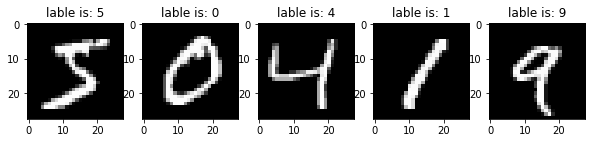

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
for img_index in range(5):
    sample = train_dataset_raw[img_index]
    img_data,label = sample[0], sample[1]
    plt.subplot(1,5,img_index+1)
    plt.imshow(img_data,cmap="gray")
    plt.title("lable is: " + str(label[0]))

- paddle支持在导入数据的同时加入各种标准化操作，以下代码演示在数据导入时加入Normalize标准化操作，并在后续使用标准后的数据进行训练

In [5]:
from paddle.vision.transforms import Compose, Normalize

# 定义所要进行的标准化操作，并在导入数据时作为transform的参数传入
transform = Compose([Normalize(mean=[127.5],std=[127.5],data_format='CHW')])

# 使用transform对数据集做归一化
print('download training data and load training data')
train_dataset = paddle.vision.datasets.MNIST(mode='train', transform=transform)
test_dataset = paddle.vision.datasets.MNIST(mode='test', transform=transform)
print('load finished')

download training data and load training data
load finished


同样的，取训练集中的前五条数据看一下。

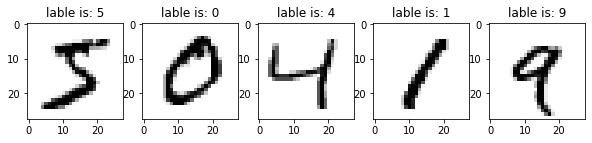

In [8]:
plt.figure(figsize=(10,5))
for img_index in range(5):
    sample = train_dataset[img_index]
    img_data,label = sample[0].reshape([28,28]), sample[1][0]
    plt.subplot(1,5,img_index+1)
    plt.imshow(img_data,cmap="gray")
    plt.imshow(img_data, cmap=plt.cm.binary)
    plt.title("lable is: " + str(label))

## 三、组网
用paddle.nn下的API，如`Conv2D`、`MaxPool2D`、`Linear`完成LeNet的构建。
LeNet的网络结构如下：

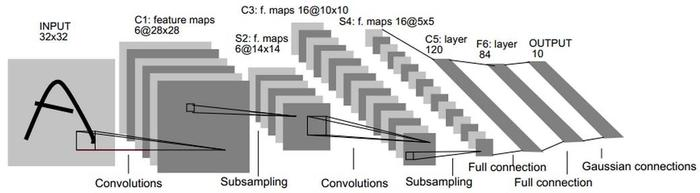

根据上图的网络结构，使用paddle中的Layer类来创建每层的网络，并定义网络的前向计算forward方法

In [10]:
class LeNet(paddle.nn.Layer):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = paddle.nn.Conv2D(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2)
        self.max_pool1 = paddle.nn.MaxPool2D(kernel_size=2,  stride=2)
        self.conv2 = paddle.nn.Conv2D(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        self.max_pool2 = paddle.nn.MaxPool2D(kernel_size=2, stride=2)
        self.linear1 = paddle.nn.Linear(in_features=16*5*5, out_features=120)
        self.linear2 = paddle.nn.Linear(in_features=120, out_features=84)
        self.linear3 = paddle.nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.max_pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool2(x)
        x = paddle.flatten(x, start_axis=1,stop_axis=-1)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        return x

 - 创建完成后，可以实例化一个网络模型，使用paddle.Model进行封装。同时可以使用 summary 功能可视化该网络结构
 - 注意：需要传入一个 Tensor，形状为 [B, C, H, W]

In [11]:
model = paddle.Model(LeNet())
model.summary((1,1,28,28))

---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Conv2D-1       [[1, 1, 28, 28]]      [1, 6, 28, 28]          156      
  MaxPool2D-1     [[1, 6, 28, 28]]      [1, 6, 14, 14]           0       
   Conv2D-2       [[1, 6, 14, 14]]     [1, 16, 10, 10]         2,416     
  MaxPool2D-2    [[1, 16, 10, 10]]      [1, 16, 5, 5]            0       
   Linear-1          [[1, 400]]            [1, 120]           48,120     
   Linear-2          [[1, 120]]            [1, 84]            10,164     
   Linear-3          [[1, 84]]             [1, 10]              850      
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
---------------------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.30
-----------------------------------------------------------------------

{'total_params': 61706, 'trainable_params': 61706}

model.summary可以输出每一层网络的输入和输出的Tensor的shape，通过此可以加深对网络的理解。你同时可以对照此结果和上面的网络结构图进行对照

## 四、方式1：基于高层API，完成模型的训练与预测
通过paddle提供的`Model` 构建实例，使用封装好的训练与测试接口，快速完成模型训练与测试。

### 4.1 使用 `Model.fit`来训练模型

In [12]:
from paddle.metric import Accuracy
optim = paddle.optimizer.Adam(learning_rate=0.001, parameters=model.parameters())

# 配置模型
model.prepare(
    optim,
    paddle.nn.CrossEntropyLoss(),
    Accuracy()
    )

上面的模型配置中：
 - Adam作为优化器
 - CrossEntroyLoss作为损失函数

In [13]:
# 训练模型
model.fit(train_dataset,
        epochs=2,
        batch_size=64,
        verbose=1
        )

The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/2
step 938/938 [==============================] - loss: 0.0322 - acc: 0.9409 - 25ms/step          
Epoch 2/2
step 938/938 [==============================] - loss: 0.0060 - acc: 0.9805 - 21ms/step          


### 4.2 使用 `Model.evaluate` 来预测模型

In [14]:
model.evaluate(test_dataset, batch_size=64, verbose=1)

Eval begin...
step 157/157 [==============================] - loss: 2.1879e-04 - acc: 0.9845 - 14ms/step      
Eval samples: 10000


{'loss': [0.00021878911], 'acc': 0.9845}

### 4.3 方式一结束
以上就是方式一，可以看到在训练集上训练两个Epoch即可达到0.98以上的准确度。
使用paddle可以快速、高效的完成网络模型训练与预测。

## 五、方式2：基于基础API，完成模型的训练与预测
### 5.1 模型训练
组网后，开始对模型进行训练，先构建`train_loader`，加载训练数据，然后定义`train`函数，设置好损失函数后，按batch加载数据，完成模型的训练。

In [15]:
train_loader = paddle.io.DataLoader(train_dataset, batch_size=64, shuffle=True)
# 加载训练集 batch_size 设为 64
def train(model):
    model.train()
    epochs = 2
    optim = paddle.optimizer.Adam(learning_rate=0.001, parameters=model.parameters())
    # 用Adam作为优化函数
    for epoch in range(epochs):
        for batch_id, data in enumerate(train_loader()):
            x_data = data[0]
            y_data = data[1]
            predicts = model(x_data)
            loss = F.cross_entropy(predicts, y_data)
            # 计算损失
            acc = paddle.metric.accuracy(predicts, y_data)
            loss.backward()
            if batch_id % 300 == 0:
                print("epoch: {}, batch_id: {}, loss is: {}, acc is: {}".format(epoch, batch_id, loss.numpy(), acc.numpy()))
            optim.step()
            optim.clear_grad()
model = LeNet()
train(model)

epoch: 0, batch_id: 0, loss is: [2.871272], acc is: [0.046875]
epoch: 0, batch_id: 300, loss is: [0.16640224], acc is: [0.9375]
epoch: 0, batch_id: 600, loss is: [0.17503175], acc is: [0.90625]
epoch: 0, batch_id: 900, loss is: [0.09523699], acc is: [0.953125]
epoch: 1, batch_id: 0, loss is: [0.10589785], acc is: [0.96875]
epoch: 1, batch_id: 300, loss is: [0.03043577], acc is: [1.]
epoch: 1, batch_id: 600, loss is: [0.00428317], acc is: [1.]
epoch: 1, batch_id: 900, loss is: [0.00943627], acc is: [1.]


### 5.2 模型验证
训练完成后，需要验证模型的效果，此时，加载测试数据集，然后用训练好的模对测试集进行预测，计算损失与精度。

In [16]:
test_loader = paddle.io.DataLoader(test_dataset, places=paddle.CPUPlace(), batch_size=64)
# 加载测试数据集
def test(model):
    model.eval()
    batch_size = 64
    for batch_id, data in enumerate(test_loader()):
        x_data = data[0]
        y_data = data[1]
        predicts = model(x_data)
        # 获取预测结果
        loss = F.cross_entropy(predicts, y_data)
        acc = paddle.metric.accuracy(predicts, y_data)
        if batch_id % 20 == 0:
            print("batch_id: {}, loss is: {}, acc is: {}".format(batch_id, loss.numpy(), acc.numpy()))
test(model)

batch_id: 0, loss is: [0.00868245], acc is: [1.]
batch_id: 20, loss is: [0.06536089], acc is: [0.96875]
batch_id: 40, loss is: [0.08521771], acc is: [0.984375]
batch_id: 60, loss is: [0.06948927], acc is: [0.984375]
batch_id: 80, loss is: [0.00606692], acc is: [1.]
batch_id: 100, loss is: [0.00359494], acc is: [1.]
batch_id: 120, loss is: [0.01098465], acc is: [1.]
batch_id: 140, loss is: [0.11846533], acc is: [0.96875]


### 5.3 方式二结束
以上就是方式二，通过底层API，可以清楚的看到训练和测试中的每一步过程。但是，这种方式比较复杂。因此，我们提供了训练方式一，使用高层API来完成模型的训练与预测。对比底层API，高层API能够更加快速、高效的完成模型的训练与测试。

## 六、总结


以上就是用LeNet对手写数字数据及MNIST进行分类。本示例提供了两种训练模型的方式，一种可以快速完成模型的组建与预测，非常适合新手用户上手。另一种则需要多个步骤来完成模型的训练，适合进阶用户使用。